### VGG19

#### Importing Packages

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications.vgg19 import VGG19
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.models import Sequential
from keras.regularizers import l2
from keras import regularizers
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import tensorflow
np.random.seed(1)

In [ ]:
# # mount google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


#### Reading the data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Nature/Nature_Training_Set.csv')

In [ ]:
len(df['Label'].unique())

35

#### Data Preprocessing

In [ ]:
train_images = [] 
shape = (200,200)  
train_path = r'/content/gdrive/MyDrive/Nature/Train Files'



for i in tqdm(range(df.shape[0])):
    try:
        img = cv2.imread(os.path.join(train_path,str(df['FileName'][i])+'.jpg'))
        img = cv2.resize(img,shape)
        train_images.append(img)
    except Exception as e:
        print(str(e))

100%|██████████| 15000/15000 [2:09:05<00:00,  1.94it/s]


In [ ]:
y = df['Label'].values
y = np_utils.to_categorical(y,36)


# Converting labels into One Hot encoded sparse matrix
#train_labels = pd.get_dummies(train_labels).values

# Converting train_images to array
train_images = np.array(train_images)


# Splitting Training data into train and validation dataset
x_train,x_val,y_train,y_val = train_test_split(train_images,y,random_state=1)
x_train = x_train.astype("float32") / 255
x_val = x_val.astype("float32") / 255

In [ ]:
df.sample()

,FileName,Label
7576,45605629,26


In [ ]:
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

#### Model Creation

In [ ]:
pre_trained_model = VGG19(input_shape=(200,200,3), include_top=False, weights="imagenet")
#pre_trained_model.trainable = False

for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

model = Sequential([
    pre_trained_model,
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(36 , activation='softmax')])
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 512)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 36)                165924    
                                                                 
Total params: 20,190,308
Trainable params: 4,885,540
Non-trainable params: 15,304,768
_________________________________________________________________


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.6, min_lr=0.000001)

In [ ]:
with tensorflow.device('/gpu:0'):
  history1 = model.fit(x_train,y_train, batch_size = 64 , epochs = 10 , validation_data = (x_val, y_val),callbacks = [learning_rate_reduction])

Epoch 1/10
176/176 [==============================] - 38s 213ms/step - loss: 1.5677 - accuracy: 0.5492 - val_loss: 1.0274 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 2/10
176/176 [==============================] - 36s 203ms/step - loss: 0.7309 - accuracy: 0.7787 - val_loss: 0.9725 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 3/10
176/176 [==============================] - 36s 203ms/step - loss: 0.4732 - accuracy: 0.8502 - val_loss: 0.9395 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 4/10
176/176 [==============================] - 36s 203ms/step - loss: 0.3107 - accuracy: 0.9030 - val_loss: 0.9462 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 5/10
176/176 [==============================] - 36s 203ms/step - loss: 0.1958 - accuracy: 0.9364 - val_loss: 1.2511 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 6/10
176/176 [==============================] - 36s 203ms/step - loss: 0.1657 - accuracy: 0.9458 - val_loss: 1.2310 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 7/10
176/176 [==============================] 

In [ ]:
model.save("Nature.h5")

In [ ]:
score = model.evaluate(x_val, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1234015226364136
Test accuracy: 0.8069333434104919


#### Predicting the test set

In [ ]:
df_test = pd.read_csv('/content/Nature_Test_Set.csv')

In [ ]:
df_test

,FileName,Label
0,51306401,NaN
1,67968696,NaN
2,23128722,NaN
3,49893925,NaN
4,53534042,NaN
...,...,...
1521,98451885,NaN
1522,20675384,NaN
1523,38444337,NaN
1524,98440809,NaN


In [ ]:
test_image = [] 
shape = (200,200)  
test_path = r'/content/gdrive/MyDrive/Nature Test Image Files/'

for i in tqdm(range(df_test.shape[0])):
    try:
        img = cv2.imread(os.path.join(test_path,str(df_test['FileName'][i])+'.jpg'))
        img = cv2.resize(img,shape)
        test_image.append(img)
    except Exception as e:
        print(str(e))
test_image = np.array(test_image)
test_image = test_image.astype("float32") / 255

100%|██████████| 1526/1526 [04:20<00:00,  5.87it/s]


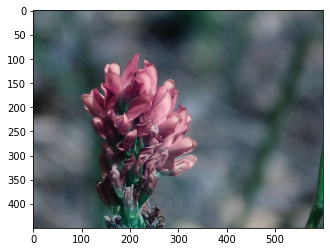

In [ ]:
plt.imshow(cv2.imread(os.path.join(test_path,str(21487428)+'.jpg')))

In [ ]:
y_pred = model.predict(test_image)
labels = np.argmax(y_pred,axis=1)
# labels.append(label)

In [ ]:
df_test['Label'] = list(labels)

In [ ]:
df_test.to_csv('N.csv')

In [ ]:
y_pred_inv = label_binarizer.inverse_transform(y_pred)

In [ ]:
y_pred_inv[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
np.argmax(y_pred,axis=1)

array([20])

In [ ]:
test = ['94777582.jpg',
'75442745.jpg',
'70521595.jpg',
'70211227.jpg',
'59431852.jpg',
'33233882.jpg',
'20219926.jpg',
'19462688.jpg',
'18408112.jpg']

test_images = [] 
shape = (200,200)  
test_path = r'/home/pgodbole2/Nature/Train Files/'

for i in tqdm(range(len(test))):
    try:
        img = cv2.imread(os.path.join(test_path,test[i]))
        img = cv2.resize(img,shape)
        test_images.append(img)
    except Exception as e:
        print(str(e))
test_images = np.array(test_images)
test_images = test_images.astype("float32") / 255

100%|██████████| 9/9 [00:00<00:00, 89.95it/s]


In [ ]:
y_pred = model.predict(test_images)

In [ ]:
y_pred_inv = label_binarizer.inverse_transform(y_pred)

In [ ]:
y_pred_inv

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


In [ ]:
np.argmax(y_pred,axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Experimenting Another VGG Model

In [ ]:
pre_trained_model = VGG19(input_shape=(200,200,3), include_top=False, weights="imagenet")
#pre_trained_model.trainable = False

for layer in pre_trained_model.layers[:21]:
    layer.trainable = False

model = Sequential([
    pre_trained_model,
    # BatchNormalization(),
    MaxPool2D((2,2) , strides = 2),
    Dropout(0.2),
    Flatten(),
    Dense(36 , activation='softmax')])
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 512)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 36)                165924    
                                                                 
Total params: 20,190,308
Trainable params: 165,924
Non-trainable params: 20,024,384
____________________________________

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.6, min_lr=0.000001)

In [ ]:
import tensorflow
with tensorflow.device('/gpu:0'):
  history2 = model.fit(x_train,y_train, batch_size = 64 , epochs = 5 , validation_data = (x_val, y_val),callbacks = [learning_rate_reduction])

Epoch 1/5
176/176 [==============================] - 39s 216ms/step - loss: 2.1392 - accuracy: 0.4276 - val_loss: 1.5634 - val_accuracy: 0.5960 - lr: 0.0010
Epoch 2/5
176/176 [==============================] - 35s 197ms/step - loss: 1.2290 - accuracy: 0.6713 - val_loss: 1.3259 - val_accuracy: 0.6251 - lr: 0.0010
Epoch 3/5
176/176 [==============================] - 35s 197ms/step - loss: 0.9688 - accuracy: 0.7399 - val_loss: 1.1466 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 4/5
 92/176 [==============>...............] - ETA: 12s - loss: 0.8053 - accuracy: 0.7877